In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.models import alexnet
import torch.nn.functional as F
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from AlexNetLastTwoLayers import AlexNetLastTwoLayers
from PrototypicalNetworks import PrototypicalNetworks
from PrototypicalFlagNetworks import PrototypicalFlagNetworks
from easyfsl.datasets import WrapFewShotDataset


import copy

from statistics import mean

from matplotlib import pyplot as plt

In [9]:
def count_accuracy(logits, label):
    pred = torch.argmax(logits, dim=1).view(-1)
    label = label.view(-1)
    accuracy = 100 * pred.eq(label).float().mean()
    return accuracy

def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).cuda()
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies

def training_epoch(model_, data_loader, optimizer):
    all_loss = []
    model_.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()

            logit_query = model_(support_images.cuda(), support_labels.cuda(), query_images.cuda())

            train_way = len(torch.unique(support_labels))
            smoothed_one_hot = one_hot(query_labels.reshape(-1).cuda(), train_way)
            log_prb = F.log_softmax(logit_query.reshape(-1, train_way), dim=1)
            loss = -(smoothed_one_hot * log_prb).sum(dim=1)
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

def val_evaluate(model_, val_loader):
    model_.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed during validation
        for val_support_images, val_support_labels, val_query_images, val_query_labels, _ in val_loader:
            # Obtain validation predictions
            val_preds = model_(val_support_images.cuda(), val_support_labels.cuda(), val_query_images.cuda())
            
            # Count correct predictions
            correct += (val_preds.argmax(dim=2).reshape(-1) == val_query_labels.cuda()).sum().item()
            total += val_query_labels.size(0)

    # Calculate validation accuracy
    val_accuracy = correct / total
    return val_accuracy

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
random_seed = 0
# np.random.seed(random_seed)
torch.manual_seed(random_seed)
# random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:

transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
)


train_data = WrapFewShotDataset(CIFAR10(
    root="../data",
    transform= transform,
    download=True,
    train = True
))

test_data = WrapFewShotDataset(CIFAR10(
    root="../data",
    transform=transform,
    download=True,
    train = False   
))


# split of training data into train and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])


Files already downloaded and verified
Files already downloaded and verified


In [13]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
val_subset.get_labels = lambda: [
    instance[1] for instance in val_subset
]
test_data.get_labels = lambda: [
    instance[1] for instance in test_data
]

test_sampler = TaskSampler(
    test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

val_sampler = TaskSampler(
    val_subset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_data,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
    shuffle = False
)

val_loader = DataLoader(
    val_subset,
    batch_sampler=val_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
    shuffle = False
)



N_TASKS_PER_EPOCH = 500
N_VALIDATION_TASKS = 100

train_data.get_labels = lambda: [instance[1] for instance in train_data]

train_sampler = TaskSampler(
    train_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TASKS_PER_EPOCH
)

train_loader = DataLoader(
    train_data,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0


Training: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s, loss=0.627]


Ding ding ding! We found a new best model! 0.8364
Epoch 1


Training: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, loss=0.416]


Ding ding ding! We found a new best model! 0.8716
Epoch 2


Training: 100%|██████████| 500/500 [01:23<00:00,  5.96it/s, loss=0.342]


Ding ding ding! We found a new best model! 0.8946
Epoch 3


Training: 100%|██████████| 500/500 [01:22<00:00,  6.05it/s, loss=0.314]


Ding ding ding! We found a new best model! 0.8962
Epoch 4


Training: 100%|██████████| 500/500 [01:27<00:00,  5.70it/s, loss=0.28] 


Ding ding ding! We found a new best model! 0.9082
Epoch 5


Training: 100%|██████████| 500/500 [01:26<00:00,  5.78it/s, loss=0.268]


Ding ding ding! We found a new best model! 0.9244
Epoch 6


Training: 100%|██████████| 500/500 [01:28<00:00,  5.68it/s, loss=0.242]


Ding ding ding! We found a new best model! 0.9304
Epoch 7


Training: 100%|██████████| 500/500 [01:27<00:00,  5.69it/s, loss=0.229]


Epoch 8


Training: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, loss=0.215]


Epoch 9


Training: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s, loss=0.202]


Ding ding ding! We found a new best model! 0.9412
Epoch 10


Training: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s, loss=0.201]


Ding ding ding! We found a new best model! 0.9456
Epoch 11


Training: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s, loss=0.184]


Ding ding ding! We found a new best model! 0.9512
Epoch 12


Training: 100%|██████████| 500/500 [01:28<00:00,  5.66it/s, loss=0.183]


Ding ding ding! We found a new best model! 0.9542
Epoch 13


Training: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s, loss=0.174]


Ding ding ding! We found a new best model! 0.9556
Epoch 14


Training: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s, loss=0.168]


Epoch 15


Training: 100%|██████████| 500/500 [01:25<00:00,  5.82it/s, loss=0.153]


Ding ding ding! We found a new best model! 0.9582
Epoch 16


Training: 100%|██████████| 500/500 [01:27<00:00,  5.69it/s, loss=0.148]


Epoch 17


Training: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s, loss=0.15] 


Ding ding ding! We found a new best model! 0.9592
Epoch 18


Training: 100%|██████████| 500/500 [01:27<00:00,  5.68it/s, loss=0.136]


Ding ding ding! We found a new best model! 0.9614
Epoch 19


Training: 100%|██████████| 500/500 [01:25<00:00,  5.85it/s, loss=0.131]


Ding ding ding! We found a new best model! 0.966
Epoch 20


Training: 100%|██████████| 500/500 [01:25<00:00,  5.83it/s, loss=0.128]


Epoch 21


Training: 100%|██████████| 500/500 [01:26<00:00,  5.79it/s, loss=0.118]


Ding ding ding! We found a new best model! 0.969
Epoch 22


Training: 100%|██████████| 500/500 [01:22<00:00,  6.06it/s, loss=0.123]


Epoch 23


Training: 100%|██████████| 500/500 [01:22<00:00,  6.08it/s, loss=0.114]


Ding ding ding! We found a new best model! 0.9708
Epoch 24


Training: 100%|██████████| 500/500 [01:22<00:00,  6.08it/s, loss=0.107] 


Ding ding ding! We found a new best model! 0.9746
Epoch 25


Training: 100%|██████████| 500/500 [01:27<00:00,  5.70it/s, loss=0.1]   


Ding ding ding! We found a new best model! 0.9752
Epoch 26


Training: 100%|██████████| 500/500 [01:26<00:00,  5.81it/s, loss=0.104] 


Epoch 27


Training: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s, loss=0.0984]


Ding ding ding! We found a new best model! 0.9794
Epoch 28


Training: 100%|██████████| 500/500 [01:21<00:00,  6.12it/s, loss=0.0956]


Epoch 29


Training: 100%|██████████| 500/500 [01:25<00:00,  5.82it/s, loss=0.0895]


Epoch 30


Training: 100%|██████████| 500/500 [01:25<00:00,  5.84it/s, loss=0.0876]


Ding ding ding! We found a new best model! 0.9802
Epoch 31


Training: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s, loss=0.0808]


Epoch 32


Training: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s, loss=0.0732]


Ding ding ding! We found a new best model! 0.9826
Epoch 33


Training: 100%|██████████| 500/500 [01:29<00:00,  5.59it/s, loss=0.0794]


Ding ding ding! We found a new best model! 0.9848
Epoch 34


Training: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s, loss=0.0762]


Epoch 35


Training: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s, loss=0.0757]


Ding ding ding! We found a new best model! 0.9858
Epoch 36


Training: 100%|██████████| 500/500 [02:16<00:00,  3.66it/s, loss=0.0653]


Epoch 37


Training: 100%|██████████| 500/500 [02:45<00:00,  3.02it/s, loss=0.0676]


Ding ding ding! We found a new best model! 0.986
Epoch 38


Training: 100%|██████████| 500/500 [02:55<00:00,  2.85it/s, loss=0.0638]


Ding ding ding! We found a new best model! 0.9872
Epoch 39


Training: 100%|██████████| 500/500 [02:41<00:00,  3.10it/s, loss=0.0611]


Text(0, 0.5, 'Validation Accuracy')

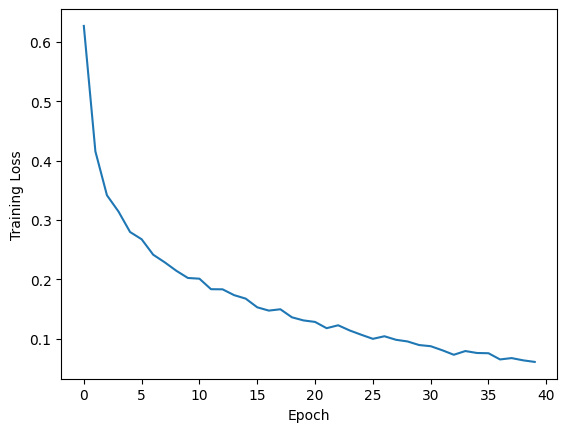

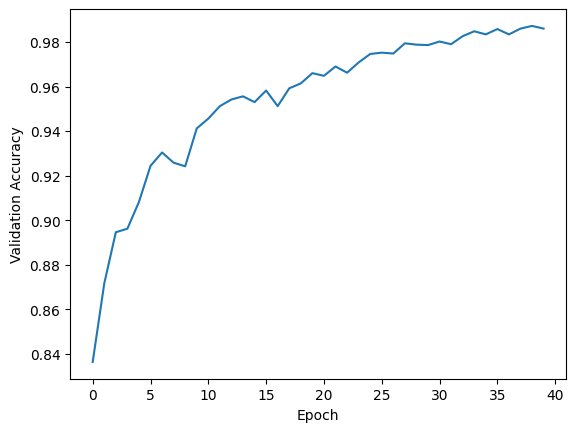

In [7]:
# Eval Protonets

backbone = alexnet(pretrained = True)
backbone.classifier[6] = nn.Flatten()
model = PrototypicalNetworks(backbone, head = 'ProtoNet').to(device)


train_optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 40

train_losses = []
val_accs = []
best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)
    validation_accuracy = val_evaluate(model, val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(model.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print(f"Ding ding ding! We found a new best model! {best_validation_accuracy}")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    # train_scheduler.step()
    train_losses.append(average_loss)
    val_accs.append(validation_accuracy)


torch.save(best_state, 'cirfar10_protonets.pth')



plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')


plt.figure()
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

Epoch 0


Training: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s, loss=0.689]


Ding ding ding! We found a new best model! 0.8178
Epoch 1


Training: 100%|██████████| 500/500 [01:30<00:00,  5.54it/s, loss=0.467]


Ding ding ding! We found a new best model! 0.8486
Epoch 2


Training: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s, loss=0.398]


Ding ding ding! We found a new best model! 0.863
Epoch 3


Training: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s, loss=0.35] 


Ding ding ding! We found a new best model! 0.9014
Epoch 4


Training: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s, loss=0.318]


Epoch 5


Training: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s, loss=0.291]


Ding ding ding! We found a new best model! 0.9102
Epoch 6


Training: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s, loss=0.285]


Epoch 7


Training: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s, loss=0.263]


Ding ding ding! We found a new best model! 0.9128
Epoch 8


Training: 100%|██████████| 500/500 [01:29<00:00,  5.57it/s, loss=0.246]


Ding ding ding! We found a new best model! 0.9156
Epoch 9


Training: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s, loss=0.241]


Ding ding ding! We found a new best model! 0.9308
Epoch 10


Training: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s, loss=0.217]


Epoch 11


Training: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s, loss=0.21] 


Ding ding ding! We found a new best model! 0.9324
Epoch 12


Training: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s, loss=0.211]


Ding ding ding! We found a new best model! 0.9334
Epoch 13


Training: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s, loss=0.198]


Ding ding ding! We found a new best model! 0.9382
Epoch 14


Training: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s, loss=0.191]


Ding ding ding! We found a new best model! 0.941
Epoch 15


Training: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s, loss=0.178]


Ding ding ding! We found a new best model! 0.9452
Epoch 16


Training: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s, loss=0.176]


Ding ding ding! We found a new best model! 0.9478
Epoch 17


Training: 100%|██████████| 500/500 [01:29<00:00,  5.56it/s, loss=0.161]


Ding ding ding! We found a new best model! 0.9514
Epoch 18


Training: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s, loss=0.156]


Epoch 19


Training: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s, loss=0.152]


Ding ding ding! We found a new best model! 0.9536
Epoch 20


Training: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s, loss=0.148]


Epoch 21


Training: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s, loss=0.146]


Ding ding ding! We found a new best model! 0.961
Epoch 22


Training: 100%|██████████| 500/500 [01:43<00:00,  4.85it/s, loss=0.144]


Epoch 23


Training: 100%|██████████| 500/500 [02:27<00:00,  3.40it/s, loss=0.137]


Ding ding ding! We found a new best model! 0.9668
Epoch 24


Training: 100%|██████████| 500/500 [02:42<00:00,  3.08it/s, loss=0.132]


Epoch 25


Training: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s, loss=0.125]


Epoch 26


Training: 100%|██████████| 500/500 [02:26<00:00,  3.42it/s, loss=0.121]


Ding ding ding! We found a new best model! 0.9682
Epoch 27


Training: 100%|██████████| 500/500 [01:44<00:00,  4.76it/s, loss=0.119]


Epoch 28


Training: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s, loss=0.114]


Ding ding ding! We found a new best model! 0.9694
Epoch 29


Training: 100%|██████████| 500/500 [01:40<00:00,  5.00it/s, loss=0.112]


Epoch 30


Training: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s, loss=0.104]


Ding ding ding! We found a new best model! 0.971
Epoch 31


Training: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s, loss=0.108]


Ding ding ding! We found a new best model! 0.9782
Epoch 32


Training: 100%|██████████| 500/500 [01:37<00:00,  5.12it/s, loss=0.104]


Epoch 33


Training: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s, loss=0.0931]


Epoch 34


Training: 100%|██████████| 500/500 [01:37<00:00,  5.13it/s, loss=0.0951]


Epoch 35


Training: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s, loss=0.0933]


Epoch 36


Training: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s, loss=0.0883]


Ding ding ding! We found a new best model! 0.98
Epoch 37


Training: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s, loss=0.0857]


Epoch 38


Training: 100%|██████████| 500/500 [01:35<00:00,  5.21it/s, loss=0.0815]


Ding ding ding! We found a new best model! 0.9828
Epoch 39


Training: 100%|██████████| 500/500 [01:39<00:00,  5.00it/s, loss=0.0805]


Text(0, 0.5, 'Validation Accuracy')

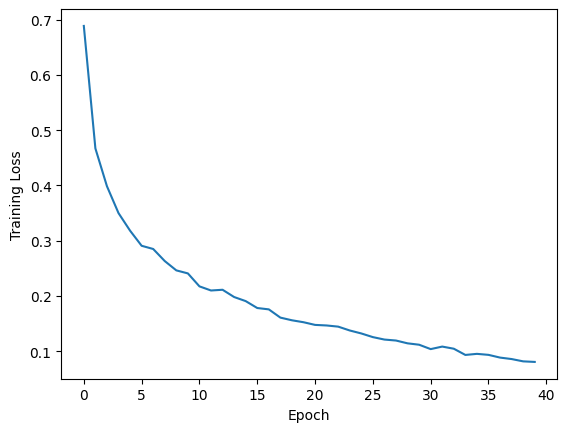

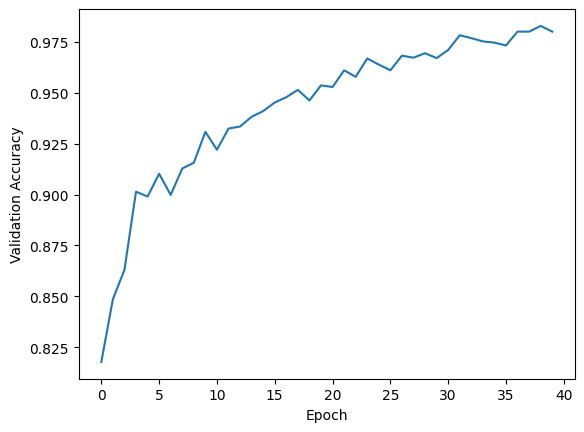

In [9]:
# Eval Subspace Nets

backbone = alexnet(pretrained = True)
backbone.classifier[6] = nn.Flatten()
model = PrototypicalNetworks(backbone, head = 'SubspaceNet').to(device)


train_optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 40

train_losses = []
val_accs = []
best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)
    validation_accuracy = val_evaluate(model, val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(model.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print(f"Ding ding ding! We found a new best model! {best_validation_accuracy}")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)


    train_losses.append(average_loss)
    val_accs.append(validation_accuracy)


torch.save(best_state, '../models/cirfar10_subspacenets.pth')


plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')


plt.figure()
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')



/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0


Training: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s, loss=0.651]


Ding ding ding! We found a new best model! 0.822
Epoch 1


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.447]


Ding ding ding! We found a new best model! 0.8718
Epoch 2


Training: 100%|██████████| 500/500 [02:22<00:00,  3.51it/s, loss=0.365]


Ding ding ding! We found a new best model! 0.895
Epoch 3


Training: 100%|██████████| 500/500 [02:22<00:00,  3.52it/s, loss=0.323]


Ding ding ding! We found a new best model! 0.9014
Epoch 4


Training: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s, loss=0.283]


Ding ding ding! We found a new best model! 0.9048
Epoch 5


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.256]


Ding ding ding! We found a new best model! 0.9178
Epoch 6


Training: 100%|██████████| 500/500 [02:22<00:00,  3.51it/s, loss=0.242]


Ding ding ding! We found a new best model! 0.9206
Epoch 7


Training: 100%|██████████| 500/500 [02:25<00:00,  3.43it/s, loss=0.228]


Ding ding ding! We found a new best model! 0.9316
Epoch 8


Training: 100%|██████████| 500/500 [02:24<00:00,  3.46it/s, loss=0.21] 


Epoch 9


Training: 100%|██████████| 500/500 [02:25<00:00,  3.44it/s, loss=0.211]


Ding ding ding! We found a new best model! 0.9382
Epoch 10


Training: 100%|██████████| 500/500 [02:22<00:00,  3.51it/s, loss=0.196]


Ding ding ding! We found a new best model! 0.9396
Epoch 11


Training: 100%|██████████| 500/500 [02:23<00:00,  3.49it/s, loss=0.187]


Ding ding ding! We found a new best model! 0.9456
Epoch 12


Training: 100%|██████████| 500/500 [02:25<00:00,  3.43it/s, loss=0.171]


Ding ding ding! We found a new best model! 0.9468
Epoch 13


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.164]


Epoch 14


Training: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, loss=0.154]


Ding ding ding! We found a new best model! 0.954
Epoch 15


Training: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s, loss=0.152]


Epoch 16


Training: 100%|██████████| 500/500 [02:26<00:00,  3.42it/s, loss=0.15] 


Ding ding ding! We found a new best model! 0.9558
Epoch 17


Training: 100%|██████████| 500/500 [02:23<00:00,  3.47it/s, loss=0.142]


Epoch 18


Training: 100%|██████████| 500/500 [02:24<00:00,  3.46it/s, loss=0.128]


Ding ding ding! We found a new best model! 0.9616
Epoch 19


Training: 100%|██████████| 500/500 [02:21<00:00,  3.52it/s, loss=0.134]


Ding ding ding! We found a new best model! 0.9618
Epoch 20


Training: 100%|██████████| 500/500 [02:27<00:00,  3.40it/s, loss=0.122]


Epoch 21


Training: 100%|██████████| 500/500 [02:26<00:00,  3.42it/s, loss=0.122]


Ding ding ding! We found a new best model! 0.9638
Epoch 22


Training: 100%|██████████| 500/500 [02:21<00:00,  3.54it/s, loss=0.113]


Ding ding ding! We found a new best model! 0.9686
Epoch 23


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.106]


Ding ding ding! We found a new best model! 0.9698
Epoch 24


Training: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s, loss=0.102] 


Ding ding ding! We found a new best model! 0.9716
Epoch 25


Training: 100%|██████████| 500/500 [02:25<00:00,  3.43it/s, loss=0.106] 


Epoch 26


Training: 100%|██████████| 500/500 [02:25<00:00,  3.44it/s, loss=0.0973]


Ding ding ding! We found a new best model! 0.9762
Epoch 27


Training: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, loss=0.0886]


Epoch 28


Training: 100%|██████████| 500/500 [02:21<00:00,  3.54it/s, loss=0.0894]


Ding ding ding! We found a new best model! 0.9802
Epoch 29


Training: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, loss=0.0838]


Epoch 30


Training: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, loss=0.0845]


Ding ding ding! We found a new best model! 0.983
Epoch 31


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.0815]


Epoch 32


Training: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, loss=0.0788]


Epoch 33


Training: 100%|██████████| 500/500 [02:21<00:00,  3.55it/s, loss=0.0731]


Epoch 34


Training: 100%|██████████| 500/500 [02:21<00:00,  3.54it/s, loss=0.066] 


Ding ding ding! We found a new best model! 0.9844
Epoch 35


Training: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s, loss=0.0697]


Epoch 36


Training: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s, loss=0.0667]


Ding ding ding! We found a new best model! 0.9856
Epoch 37


Training: 100%|██████████| 500/500 [02:21<00:00,  3.52it/s, loss=0.0641]


Ding ding ding! We found a new best model! 0.987
Epoch 38


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.0631]


Ding ding ding! We found a new best model! 0.9888
Epoch 39


Training: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, loss=0.0605]


Text(0, 0.5, 'Validation Accuracy')

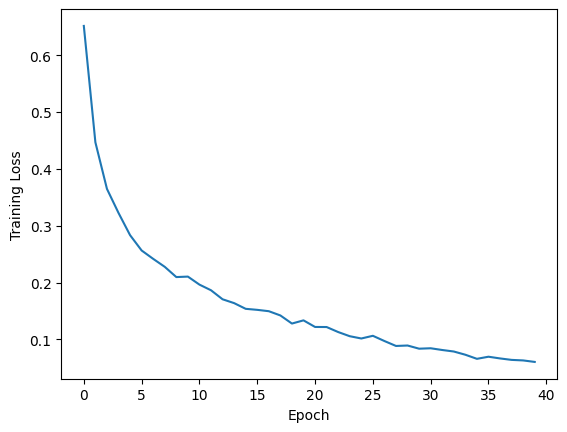

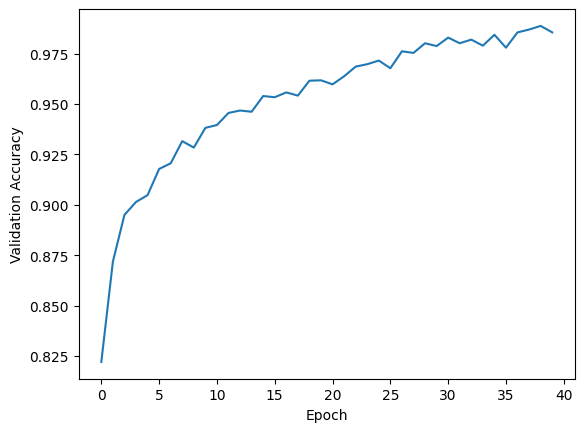

In [7]:

# Eval Subspace Nets

my_alexnet = alexnet(pretrained = True)
backbone = AlexNetLastTwoLayers(my_alexnet).to(device)
model = PrototypicalFlagNetworks(backbone).to(device)


train_optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 40

train_losses = []
val_accs = []
best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)
    validation_accuracy = val_evaluate(model, val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(model.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print(f"Ding ding ding! We found a new best model! {best_validation_accuracy}")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    train_losses.append(average_loss)
    val_accs.append(validation_accuracy)
    


torch.save(best_state, '../models/cifar10_flagnets.pth')


plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')


plt.figure()
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')




/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0


Training: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s, loss=0.875]


Ding ding ding! We found a new best model! 0.7686
Epoch 1


Training: 100%|██████████| 500/500 [02:01<00:00,  4.13it/s, loss=0.595]


Ding ding ding! We found a new best model! 0.7892
Epoch 2


Training: 100%|██████████| 500/500 [01:59<00:00,  4.17it/s, loss=0.523]


Ding ding ding! We found a new best model! 0.8244
Epoch 3


Training: 100%|██████████| 500/500 [02:06<00:00,  3.94it/s, loss=0.485]


Ding ding ding! We found a new best model! 0.851
Epoch 4


Training: 100%|██████████| 500/500 [02:09<00:00,  3.87it/s, loss=0.447]


Ding ding ding! We found a new best model! 0.8522
Epoch 5


Training: 100%|██████████| 500/500 [02:01<00:00,  4.12it/s, loss=0.432]


Ding ding ding! We found a new best model! 0.8596
Epoch 6


Training: 100%|██████████| 500/500 [02:01<00:00,  4.12it/s, loss=0.406]


Epoch 7


Training: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s, loss=0.399]


Ding ding ding! We found a new best model! 0.8684
Epoch 8


Training: 100%|██████████| 500/500 [02:04<00:00,  4.03it/s, loss=0.378]


Epoch 9


Training: 100%|██████████| 500/500 [02:00<00:00,  4.15it/s, loss=0.373]


Ding ding ding! We found a new best model! 0.8714
Epoch 10


Training: 100%|██████████| 500/500 [02:01<00:00,  4.10it/s, loss=0.352]


Ding ding ding! We found a new best model! 0.887
Epoch 11


Training: 100%|██████████| 500/500 [02:04<00:00,  4.02it/s, loss=0.351]


Epoch 12


Training: 100%|██████████| 500/500 [02:01<00:00,  4.12it/s, loss=0.343]


Epoch 13


Training: 100%|██████████| 500/500 [02:00<00:00,  4.13it/s, loss=0.332]


Ding ding ding! We found a new best model! 0.8936
Epoch 14


Training: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s, loss=0.315]


Ding ding ding! We found a new best model! 0.9026
Epoch 15


Training: 100%|██████████| 500/500 [02:00<00:00,  4.15it/s, loss=0.321]


Epoch 16


Training: 100%|██████████| 500/500 [02:03<00:00,  4.04it/s, loss=0.308]


Epoch 17


Training: 100%|██████████| 500/500 [02:03<00:00,  4.05it/s, loss=0.303]


Ding ding ding! We found a new best model! 0.9112
Epoch 18


Training: 100%|██████████| 500/500 [02:00<00:00,  4.14it/s, loss=0.3]  


Ding ding ding! We found a new best model! 0.9156
Epoch 19


Training: 100%|██████████| 500/500 [02:06<00:00,  3.94it/s, loss=0.292]


Epoch 20


Training: 100%|██████████| 500/500 [02:00<00:00,  4.14it/s, loss=0.287]


Epoch 21


Training: 100%|██████████| 500/500 [02:03<00:00,  4.04it/s, loss=0.285]


Epoch 22


Training: 100%|██████████| 500/500 [02:01<00:00,  4.10it/s, loss=0.275]


Epoch 23


Training: 100%|██████████| 500/500 [01:59<00:00,  4.19it/s, loss=0.277]


Epoch 24


Training: 100%|██████████| 500/500 [01:58<00:00,  4.22it/s, loss=0.266]


Ding ding ding! We found a new best model! 0.9278
Epoch 25


Training: 100%|██████████| 500/500 [02:02<00:00,  4.09it/s, loss=0.267]


Epoch 26


Training: 100%|██████████| 500/500 [01:57<00:00,  4.25it/s, loss=0.266]


Epoch 27


Training: 100%|██████████| 500/500 [01:58<00:00,  4.21it/s, loss=0.256]


Epoch 28


Training: 100%|██████████| 500/500 [01:59<00:00,  4.18it/s, loss=0.253]


Epoch 29


Training: 100%|██████████| 500/500 [01:57<00:00,  4.25it/s, loss=0.249]


Epoch 30


Training: 100%|██████████| 500/500 [01:58<00:00,  4.24it/s, loss=0.25] 


Ding ding ding! We found a new best model! 0.9286
Epoch 31


Training: 100%|██████████| 500/500 [02:05<00:00,  4.00it/s, loss=0.246]


Ding ding ding! We found a new best model! 0.932
Epoch 32


Training: 100%|██████████| 500/500 [02:07<00:00,  3.93it/s, loss=0.232]


Epoch 33


Training: 100%|██████████| 500/500 [02:05<00:00,  3.98it/s, loss=0.238]


Epoch 34


Training: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s, loss=0.233]


Epoch 35


Training: 100%|██████████| 500/500 [01:57<00:00,  4.25it/s, loss=0.234]


Ding ding ding! We found a new best model! 0.9344
Epoch 36


Training: 100%|██████████| 500/500 [02:00<00:00,  4.16it/s, loss=0.227]


Ding ding ding! We found a new best model! 0.9352
Epoch 37


Training: 100%|██████████| 500/500 [02:00<00:00,  4.16it/s, loss=0.22] 


Ding ding ding! We found a new best model! 0.9448
Epoch 38


Training: 100%|██████████| 500/500 [02:02<00:00,  4.08it/s, loss=0.217]


Epoch 39


Training: 100%|██████████| 500/500 [02:06<00:00,  3.94it/s, loss=0.216]


Text(0, 0.5, 'Validation Accuracy')

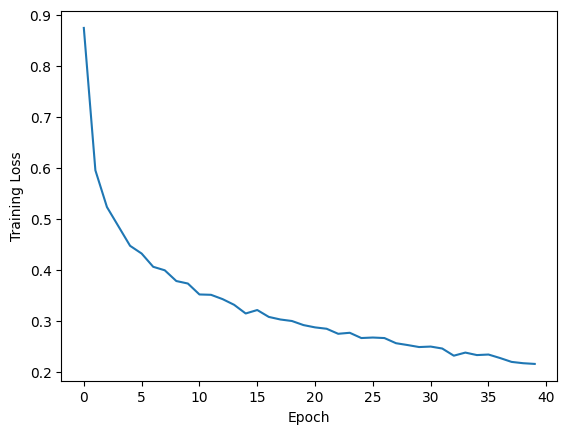

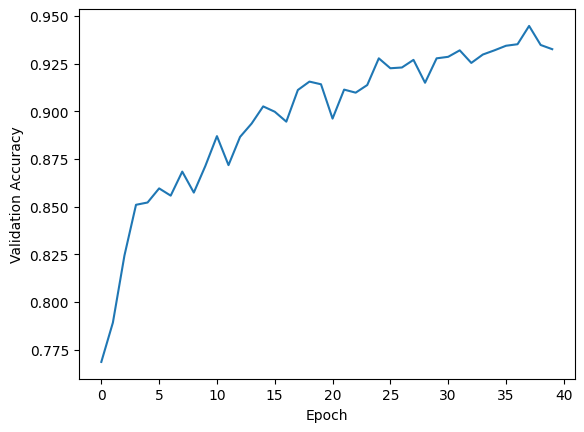

In [14]:

# Eval Subspace Nets

my_alexnet = alexnet(pretrained = True)
for param in my_alexnet.features.parameters():
    param.requires_grad = False
backbone = AlexNetLastTwoLayers(my_alexnet).to(device)
model = PrototypicalFlagNetworks(backbone).to(device)


train_optimizer = optim.Adam(model.parameters(), lr=1e-5)
n_epochs = 40

train_losses = []
val_accs = []
best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)
    validation_accuracy = val_evaluate(model, val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(model.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print(f"Ding ding ding! We found a new best model! {best_validation_accuracy}")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    train_losses.append(average_loss)
    val_accs.append(validation_accuracy)
    


torch.save(best_state, '../models/cifar10_flagnets_freeze.pth')


plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')


plt.figure()
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')


